### Importing libraries

In [1]:
from pathlib import Path
import pickle, gzip, math, os, time, shutil, matplotlib as mpl, matplotlib.pyplot as plt

### Get Data

In [2]:
MNIST_URL='https://github.com/mnielsen/neural-networks-and-deep-learning/blob/master/data/mnist.pkl.gz?raw=true'
path_data = Path('/notebooks/Course22_p2/data')
path_data.mkdir(exist_ok=True)
path_gz = path_data/'mnist.pkl.gz'

In [3]:
from urllib.request import urlretrieve
if not path_gz.exists(): urlretrieve(MNIST_URL, path_gz)

In [4]:
!ls -l /notebooks/Course22_p2/data

total 16653
-rw-r--r-- 1 root root 17051982 Apr  7 09:32 mnist.pkl.gz


In [5]:
with gzip.open(path_gz, 'rb') as f: ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')

In [6]:
type(x_train)

numpy.ndarray

When we unzip the data it returns a numpy array, we'll convert it to list so that we can implement the matrix multiplication from scratch

In [7]:
lst1 = list(x_train[0])
vals = lst1[200:210]
vals

[0.0,
 0.0,
 0.0,
 0.19140625,
 0.9296875,
 0.98828125,
 0.98828125,
 0.98828125,
 0.98828125,
 0.98828125]

Now the x_train and x_valid are a list of 784 long vectors, obtained by flattening 28*28 pixel images, we need to get the data in 28*28 shape

In [8]:
def chunks(x, sz):
    for i in range(0, len(x), sz): yield(x[i:i+sz])

In [9]:
type(chunks(lst1, 28))

generator

chunks is a generator object (it yields stuff), we can call next on it to get a batch of data

In [10]:
it = chunks(vals, 5); it

<generator object chunks at 0x7fdfcfe1a2e0>

In [11]:
next(it)

[0.0, 0.0, 0.0, 0.19140625, 0.9296875]

In [12]:
next(it)

[0.98828125, 0.98828125, 0.98828125, 0.98828125, 0.98828125]

When a generator object runs out of stuff it raises StopIteration like so

In [13]:
next(it)

StopIteration: 

If we want to get run the entire thing we can wrap it in a list

In [14]:
list(chunks(vals, 5))

[[0.0, 0.0, 0.0, 0.19140625, 0.9296875],
 [0.98828125, 0.98828125, 0.98828125, 0.98828125, 0.98828125]]

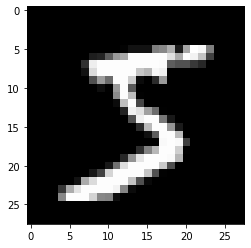

In [15]:
mpl.rcParams['image.cmap'] = 'gray'
plt.imshow(list(chunks(lst1, 28)));

In [16]:
from itertools import islice

In [17]:
it = iter(vals); type(it)

list_iterator

If we keep calling next on the iterator object it'll keep returning single value from the vals list till it runs out of things to return

In [18]:
next(it)

0.0

Or we can get a slice of object from the iterator object using islice

In [19]:
list(islice(it, 5))

[0.0, 0.0, 0.19140625, 0.9296875, 0.98828125]

In [20]:
list(islice(it, 5))

[0.98828125, 0.98828125, 0.98828125, 0.98828125]

In [21]:
list(islice(it, 5))

[]

In [22]:
iter??

Docstring:
iter(iterable) -> iterator
iter(callable, sentinel) -> iterator

Get an iterator from an object.  In the first form, the argument must
supply its own iterator, or be a sequence.
In the second form, the callable is called until it returns the sentinel.
Type:      builtin_function_or_method


#### iter
iter can take a callable (a function and a sentinel value, so we can define a lambda function using islice to get a list of list

In [23]:
it = iter(lst1)
img = list(iter(lambda: list(islice(it, 28)), []))

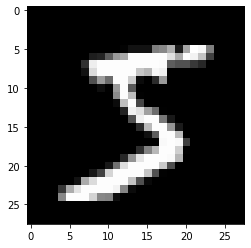

In [24]:
plt.imshow(img);

Or we can define a separate function and pass it to iter to get the same results

In [25]:
it = iter(lst1)

In [26]:
def f(): return list(islice(it, 28))

In [27]:
img = list(iter(f, []))

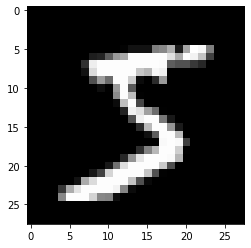

In [28]:
plt.imshow(img);

In [29]:
img[20][15]

0.98828125

### List to Matrix
So far we have to index into our list of list using [][], we want it to behave like a numpy array so we can define our class with \__getitem__

In [30]:
class Matrix:
    def __init__(self, xs): self.xs = xs
    def __getitem__(self, idxs): return self.xs[idxs[0]][idxs[1]]

In [31]:
im = Matrix(img)
im[20,15]

0.98828125

We can define our custom class to do some funky stuff like slicing

In [32]:
class MyList:
    def __init__(self, data):
        self.data = data

    def __getitem__(self, key):
        if isinstance(key, slice):
            print(f"Custom slicing: start={key.start}, stop={key.stop}, step={key.step}")
            return self.data[key.start:key.stop:key.step]
        else:
            return self.data[key]

my_list = MyList([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
print(my_list[1:8:2])

Custom slicing: start=1, stop=8, step=2
[1, 3, 5, 7]


Now that we've implemented our own class and can index into our object like matrix, we'll use tensors.

In [33]:
import torch
from torch import tensor

In [34]:
tens = tensor(img)

In [35]:
tens[20,15]

tensor(0.9883)

We can use map to change all 4 arrays to tensors

In [36]:
x_train, y_train, x_valid, y_valid = map(tensor, (x_train, y_train, x_valid, y_valid))

In [37]:
x_train.shape

torch.Size([50000, 784])

In [38]:
x_train.type()

'torch.FloatTensor'

It's a lot easier to reshape the matrices to 28*28 arrays now

In [39]:
imgs = x_train.reshape(-1,28,28)
imgs.shape

torch.Size([50000, 28, 28])

Another way of reshaping is by using .view()

In [40]:
imgs = x_train.view(-1, 28, 28)
imgs.shape

torch.Size([50000, 28, 28])

### Matrix Multiplication

In [41]:
torch.manual_seed(1)
weights = torch.randn(784,10)
bias = torch.zeros(10)

In [42]:
m1 = x_valid[:5]
m2 = weights

In [43]:
m1.shape, m2.shape

(torch.Size([5, 784]), torch.Size([784, 10]))

In [44]:
ar,ac = m1.shape
br,bc = m2.shape
(ar,ac), (br,bc)

((5, 784), (784, 10))

In [45]:
t1 = torch.zeros(ar,bc)
t1.shape

torch.Size([5, 10])

In [46]:
for i in range(ar):
    for j in range(bc):
        for k in range(ac):
            t1[i,j] += m1[i,k] * m2[k,j]

In [47]:
t1

tensor([[-10.9417,  -0.6844,  -7.0038,  -4.0066,  -2.0857,  -3.3588,   3.9127,
          -3.4375, -11.4696,  -2.1153],
        [ 14.5430,   5.9977,   2.8914,  -4.0777,   6.5914, -14.7383,  -9.2787,
           2.1577, -15.2772,  -2.6758],
        [  2.2204,  -3.2171,  -4.7988,  -6.0453,  14.1661,  -8.9824,  -4.7922,
          -5.4446, -20.6758,  13.5657],
        [ -6.7097,   8.8998,  -7.4611,  -7.8966,   2.6994,  -4.7260, -11.0278,
         -12.9776,  -6.4443,   3.6376],
        [ -2.4444,  -6.4034,  -2.3984,  -9.0371,  11.1772,  -5.7724,  -8.9214,
          -3.7862,  -8.9827,   5.2797]])

In [48]:
torch.set_printoptions(precision=2,linewidth=140, sci_mode=False)
t1

tensor([[-10.94,  -0.68,  -7.00,  -4.01,  -2.09,  -3.36,   3.91,  -3.44, -11.47,  -2.12],
        [ 14.54,   6.00,   2.89,  -4.08,   6.59, -14.74,  -9.28,   2.16, -15.28,  -2.68],
        [  2.22,  -3.22,  -4.80,  -6.05,  14.17,  -8.98,  -4.79,  -5.44, -20.68,  13.57],
        [ -6.71,   8.90,  -7.46,  -7.90,   2.70,  -4.73, -11.03, -12.98,  -6.44,   3.64],
        [ -2.44,  -6.40,  -2.40,  -9.04,  11.18,  -5.77,  -8.92,  -3.79,  -8.98,   5.28]])

In [49]:
import numpy as np
np.set_printoptions(precision=2, linewidth=140)

In [50]:
def matmul(a,b):
    t = torch.zeros(a.shape[0],b.shape[1])
    for i in range(a.shape[0]):
        for j in range(b.shape[1]):
            for k in range(a.shape[1]):
                t[i,j] += a[i,k] * b[k,j]
    return t

In [51]:
%time _=matmul(m1, m2)

CPU times: user 733 ms, sys: 71 µs, total: 733 ms
Wall time: 741 ms


In [52]:
ar*bc*ac

39200

#### Numba

Numba is a just-in-time (JIT) compiler for Python, focused on numerical and scientific computing.

It can compile a subset of Python code—especially code that uses NumPy arrays and simple loops—into fast, machine-level instructions using LLVM (Low-Level Virtual Machine).

The compiled functions run much faster than regular interpreted Python.

In [53]:
from numba import njit

In [54]:
@njit
def dot(a,b):
    res = 0.
    for i in range(len(a)): res += a[i]*b[i]
    return res

In [55]:
def matmul(a,b):
    (ar,ac), (br,bc) = a.shape, b.shape
    t = torch.zeros(ar,bc)
    for i in range(ar):
        for j in range(bc):
            #import pdb; pdb.set_trace()
            t[i, j] = dot(a[i,:], b[:,j])
    return t

In [56]:
from fastcore.test import *

In [57]:
test_close(t1, matmul(np.array(m1),np.array(m2)))

In [58]:
%timeit -n 50 matmul(np.array(m1),np.array(m2))

363 µs ± 14.6 µs per loop (mean ± std. dev. of 7 runs, 50 loops each)


Using Numba gave us ~1500x faster implementation of matrix multiplication

Matrix multiplication is when we multiply sinlge element from row of a first matrix to respective element of the column of another matrix and sum them up, we can implement it like this:

In [59]:
def matmul(a,b):
    (ar,ac), (br,bc) = a.shape, b.shape
    t = torch.zeros(ar,bc)
    for i in range(ar):
        for j in range(bc):
            t[i, j] = (a[i,:] * b[:,j]).sum()
    return t

In [60]:
test_close(t1, matmul(m1,m2))

In [61]:
%timeit -n 50 matmul(m1,m2)

978 µs ± 33.7 µs per loop (mean ± std. dev. of 7 runs, 50 loops each)


Not quite as fast as numba but still pretty good compared to our pure Python implementation. Or we can use torch.dot which does the same thing.

In [62]:
def matmul(a,b):
    (ar,ac), (br,bc) = a.shape, b.shape
    t = torch.zeros(ar,bc)
    for i in range(ar):
        for j in range(bc):
            t[i, j] = torch.dot(a[i,:] , b[:,j])
    return t

In [63]:
test_close(t1, matmul(m1,m2))

In [64]:
%timeit -n 50 matmul(m1,m2)

606 µs ± 29.7 µs per loop (mean ± std. dev. of 7 runs, 50 loops each)


## Broadcasting

The term **broadcasting** describes how arrays with different shapes are treated during arithmetic operations.

From the [Numpy Documentation](https://docs.scipy.org/doc/numpy-1.10.0/user/basics.broadcasting.html):

    The term broadcasting describes how numpy treats arrays with 
    different shapes during arithmetic operations. Subject to certain 
    constraints, the smaller array is “broadcast” across the larger 
    array so that they have compatible shapes. Broadcasting provides a 
    means of vectorizing array operations so that looping occurs in C
    instead of Python. It does this without making needless copies of 
    data and usually leads to efficient algorithm implementations.
    
In addition to the efficiency of broadcasting, it allows developers to write less code, which typically leads to fewer errors.

*This section was adapted from [Chapter 4](http://nbviewer.jupyter.org/github/fastai/numerical-linear-algebra/blob/master/nbs/4.%20Compressed%20Sensing%20of%20CT%20Scans%20with%20Robust%20Regression.ipynb#4.-Compressed-Sensing-of-CT-Scans-with-Robust-Regression) of the fast.ai [Computational Linear Algebra](https://github.com/fastai/numerical-linear-algebra) course.*

In [70]:
c = tensor([10.,20,30]); c

tensor([10., 20., 30.])

In [71]:
m = tensor([[1., 2, 3], [4,5,6], [7,8,9]]); m

tensor([[1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]])

In [72]:
m.shape, c.shape

(torch.Size([3, 3]), torch.Size([3]))

In [73]:
m + c

tensor([[11., 22., 33.],
        [14., 25., 36.],
        [17., 28., 39.]])

Here the 10, 20, 30 got added to each column because the boradcasting checked the last dimension of m which is 3 matches with the last dimension of c, if we wanted to add 10, 20, 30 to rows, we'll have to add a unit dimension to c like this

In [74]:
c.unsqueeze(1).shape

torch.Size([3, 1])

In [75]:
m + c.unsqueeze(1)

tensor([[11., 12., 13.],
        [24., 25., 26.],
        [37., 38., 39.]])

In [76]:
t = c.expand_as(m); t

tensor([[10., 20., 30.],
        [10., 20., 30.],
        [10., 20., 30.]])

Broadcasting sorta copies the data over in the dimension it's trying to match but if we look at the storage we can see that it still has only 1 column

In [77]:
t.storage()

 10.0
 20.0
 30.0
[torch.FloatStorage of size 3]

In [78]:
m + t

tensor([[11., 22., 33.],
        [14., 25., 36.],
        [17., 28., 39.]])

In [79]:
t.stride(), t.shape

((0, 1), torch.Size([3, 3]))

A stride in a PyTorch tensor tells you how many memory steps (elements) you need to move to go to the next element along each dimension.

For a tensor with shape (3, 3), a stride of (0, 1) means:

Stride 0 in dim 0 (rows) means:

Moving down one row in t does not advance in memory—it reuses the same value.

Stride 1 in dim 1 (cols) means:

Each "column" appears to step 1 index in memory—but this is just a logical layout, not real memory.

No new memory is created, we can confirm using:

In [80]:
print("Memory address of c:", c.data_ptr())
print("Memory address of t:", t.data_ptr())

Memory address of c: 49752064
Memory address of t: 49752064


In [81]:
c, c.shape

(tensor([10., 20., 30.]), torch.Size([3]))

There are other ways of adding dimensions to a tensor.

In [82]:
c.unsqueeze(0).shape, c[None, :].shape

(torch.Size([1, 3]), torch.Size([1, 3]))

In [83]:
c.unsqueeze(1).shape, c[:, None].shape

(torch.Size([3, 1]), torch.Size([3, 1]))

In [84]:
# ... means all dimensions
c.shape, c[None].shape, c[...,None].shape, c[None,...].shape

(torch.Size([3]), torch.Size([1, 3]), torch.Size([3, 1]), torch.Size([1, 3]))

In [85]:
digit = m1[0]
digit.shape,m2.shape

(torch.Size([784]), torch.Size([784, 10]))

Here we can see broadcasting in action, we can add a unit dimenson to digit and then pytorch can broadcast the unit axis to the number of elements of m2

In [86]:
(digit[:,None]*m2).shape, (digit[:,None]*m2).sum(dim=0).shape

(torch.Size([784, 10]), torch.Size([10]))

And we can then use this trick to compute the matrix multiplication using just a single loop

In [87]:
def matmul(a,b):
    (ar,ac), (br,bc) = a.shape, b.shape
    t = torch.zeros(ar,bc)
    for i in range(ar):
        t[i] = (a[i,:,None] * b).sum(dim=0)
    return t

In [88]:
m2.shape, m1[0,:,None].shape

(torch.Size([784, 10]), torch.Size([784, 1]))

In [89]:
test_close(t1, matmul(m1,m2))

In [90]:
%timeit -n 50 matmul(m1,m2)

166 µs ± 19.2 µs per loop (mean ± std. dev. of 7 runs, 50 loops each)


And it's even faster, we're around 3000x faster than the pure python implementation of the matrix multiplication

In [91]:
m1.shape, m2.shape

(torch.Size([5, 784]), torch.Size([784, 10]))

In [92]:
torch.manual_seed(42)
a = torch.randn(4)
b = torch.randn(5)
a,b

(tensor([0.34, 0.13, 0.23, 0.23]), tensor([-1.12, -0.19,  2.21, -0.64,  0.46]))

### Einstein summation

In [93]:
c = torch.einsum('i,j->ij',a,b); c

tensor([[-0.38, -0.06,  0.74, -0.21,  0.16],
        [-0.14, -0.02,  0.28, -0.08,  0.06],
        [-0.26, -0.04,  0.52, -0.15,  0.11],
        [-0.26, -0.04,  0.51, -0.15,  0.11]])

The way the above summation works is:

c[0,0] = a[0] * b[0], c[0,1] = a[0] * b[1], c[0,2] = a[0] * b[2] etc.

We can remove the dimension to get the matrix multiplication

In [94]:
torch.einsum('ij,jk->ik', torch.randn(2,3),torch.randn(3,4))

tensor([[ 0.50,  1.30,  0.63,  0.04],
        [ 1.55, -1.10, -0.31, -0.81]])

In [95]:
result = torch.einsum('i,i->', a,a)
print(result)  # sum of squares

tensor(0.24)


In [96]:
(a*a).sum()

tensor(0.24)

In [97]:
torch.manual_seed(42)
As = torch.randn(3, 2, 5)
Bs = torch.randn(3, 5, 4)
As,Bs

(tensor([[[ 1.93,  1.49,  0.90, -2.11,  0.68],
          [-1.23, -0.04, -1.60, -0.75,  1.65]],
 
         [[-0.39, -1.40, -0.73, -0.56, -2.32],
          [-0.22, -1.38, -0.87, -0.22,  1.72]],
 
         [[ 0.32, -0.42, -0.83,  0.33, -1.56],
          [ 1.00, -0.88, -0.60, -1.27,  2.12]]]),
 tensor([[[-1.09, -0.36, -0.91, -0.66],
          [ 0.08,  0.53, -0.49,  1.19],
          [-1.39, -1.29, -1.40,  0.04],
          [-0.06,  0.68, -0.10,  1.84],
          [ 1.39, -0.45,  1.45,  0.86]],
 
         [[ 2.22,  0.52,  0.35, -0.20],
          [-0.45, -0.77, -0.17,  0.52],
          [ 0.06,  0.43,  0.58, -0.64],
          [ 0.34,  1.70,  0.01, -0.34],
          [-1.34, -0.59,  0.54,  0.52]],
 
         [[-1.47,  1.43,  0.74, -0.48],
          [ 0.19, -0.36, -0.32,  0.59],
          [-0.89,  0.41, -1.46, -0.10],
          [ 0.35,  0.62, -0.17,  0.23],
          [ 4.04,  1.28, -0.01,  0.24]]]))

In [98]:
As[:,0,1]

tensor([ 1.49, -1.40, -0.42])

In [99]:
torch.einsum(As, [..., 0, 1], Bs, [..., 1, 2], [..., 0, 2]).shape

torch.Size([3, 2, 4])

In [100]:
A = torch.randn(3, 5, 4)
l = torch.randn(2, 5)
r = torch.randn(2, 4)

In [101]:
p = torch.einsum('ab,cbd->acd',l,A); p.shape

torch.Size([2, 3, 4])

In [102]:
q = torch.einsum('abc,ac->ab',p,r)

In [103]:
s = torch.einsum('ab,cbd,ad->ac',l,A,r)

In [104]:
test_close(q,s)

In [105]:
def matmul(a,b): return torch.einsum('ij,jk->ik',a,b)

In [106]:
test_close(t1, matmul(m1,m2))

In [107]:
%timeit -n 5 _=matmul(x_train, weights)

14.9 ms ± 1.13 ms per loop (mean ± std. dev. of 7 runs, 5 loops each)


In [108]:
test_close(t1, (m1@m2))

#### Pytorch matrix multiplication

In [109]:
tr = x_train@weights

In [110]:
%timeit -n 5 _= x_train@weights

13.6 ms ± 1.37 ms per loop (mean ± std. dev. of 7 runs, 5 loops each)


In [111]:
tr.shape

torch.Size([50000, 10])

#### CUDA

In [112]:
from numba import cuda

In [113]:
@cuda.jit
def matmul(a, b, c):
    i, j = cuda.grid(2)
    if i < c.shape[0] and j < c.shape[1]:
        tmp = 0.
        for k in range(a.shape[1]):
            tmp += a[i,k] * b[k,j]
        c[i,j] = tmp

In [114]:
r = np.zeros((x_train.shape[0], weights.shape[1]))
m1g, m2g, rg = map(cuda.to_device, (x_train, weights, r))

In [115]:
TPB = 16
rr,rc = r.shape
blockspergrid = (math.ceil(rr/TPB), math.ceil(rc/TPB))
blockspergrid

(3125, 1)

In [116]:
matmul[blockspergrid, (TPB,TPB)](m1g,m2g,rg)
r = rg.copy_to_host()
test_close(tr, r, eps=1e-3)

In [117]:
r.shape

(50000, 10)

In [118]:
%%timeit -n 10
matmul[blockspergrid, (TPB,TPB)](m1g,m2g,rg)
r = rg.copy_to_host()

6.17 ms ± 407 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [119]:
m1c, m2c = x_train.cuda(), weights.cuda()

In [120]:
r=(m1c@m2c).cpu()

In [121]:
%timeit -n 10 r=(m1c@m2c).cpu()

1.69 ms ± 272 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
